In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
##Checking GPU
!nvidia-smi

Tue Dec 19 17:29:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
##Visualizing Data
import pandas as pd
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
##Checking the test data also..
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
##Checking shapes of train,test data
train_df.shape,test_df.shape

((7613, 5), (3263, 4))

In [7]:
#Total samples
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [8]:
#Checking number of example classes
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@KMacTWN @meaganerd Looks like a bowl of weather cereal. New! Kellogg's Sugar Hail! Stays crunchy even in milk...

---

Target: 0 (not real disaster)
Text:
Listen LIve: http://t.co/1puLaekxcq #Author #Interview Beth Underwood of #Gravity on #Military #Mom #TalkRadio

---

Target: 1 (real disaster)
Text:
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring

---

Target: 1 (real disaster)
Text:
Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06

---

Target: 0 (not real disaster)
Text:
Element of Freedom: The Biggest Party of the Summer @ Mirage Saturday! Tickets at http://t.co/7hAnPcr5rK

---



**Splitting the data into training and testing using train_test_split**

In [10]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2, 
                                                                            random_state=42)

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6090, 6090, 1523, 1523)

In [12]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

**Tokenization**

In [13]:
##Converting the text into numbers
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization 
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [14]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

##We find the max length or max tokens by finding average number of tokens
##round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))##
##It is approximately 15##

In [15]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [16]:
# Create sample sentence and checking the tokenization 
sample_sentence = "I Love Data Science"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8,  110,  668, 1831,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

**Taking the data in random is a great practice in machine learning**


In [17]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@beauscoven nah man he's panicking. He just found out his brothers had it off with his now wife debbie is in hospital he's stressed      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 1660,   89,  295,  467,   59,   31,  215,   36,   76, 3741,
          98,   15,  102,   14]])>

**Getting the top five unique words in the data**

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


**Embedding the data**

In [19]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [20]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
San Antonio Stars head coach Dan Hughes was just carted to the locker room after one of his guards collided with... http://t.co/4dbhOnO3Rk      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03834356, -0.0255775 ,  0.03073705, ..., -0.02988175,
          0.00117096, -0.02440715],
        [-0.03295695, -0.04384612, -0.01877295, ...,  0.0413699 ,
          0.04910309,  0.04839451],
        [-0.00689939,  0.02743817, -0.03088255, ...,  0.01505827,
         -0.0363458 ,  0.04538958],
        ...,
        [-0.02380965, -0.04177911, -0.02220402, ...,  0.00915496,
         -0.04157734,  0.04108746],
        [ 0.01931384,  0.0116317 ,  0.03454784, ..., -0.03656244,
          0.03321897,  0.04596737],
        [-0.04153113,  0.03509578,  0.03772824, ...,  0.01810456,
          0.02128166,  0.00549854]]], dtype=float32)>

In [21]:
##Checking single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03834356, -0.0255775 ,  0.03073705, -0.022497  , -0.01218524,
       -0.01219184,  0.02677223, -0.00978038, -0.00874453,  0.04684119,
       -0.01601186,  0.04222591, -0.04869889, -0.01146116,  0.04988417,
       -0.03858147,  0.01025956,  0.04530982,  0.03028545,  0.04841715,
       -0.01341539,  0.03224862,  0.02106361, -0.04527681,  0.01520475,
        0.03883031,  0.00546215, -0.04551313, -0.03495836, -0.00717652,
        0.00911272,  0.00932604,  0.03771785, -0.01478636,  0.00206666,
        0.04732449, -0.00931102,  0.00496075, -0.03003901, -0.02736089,
       -0.04427443,  0.04137336, -0.03729821, -0.00969771,  0.0444483 ,
        0.00598676,  0.04966487,  0.0202211 , -0.016364  ,  0.00544307,
       -0.01849865,  0.01710698,  0.01016428,  0.01599599, -0.01115599,
        0.04649648,  0.00676942,  0.04811117, -0.04050358, -0.00876727,
       -0.04187924,  0.04915449, -0.02597921, -0.02602145, -0.04226012,
       -0.007248

**We are creating the three models and comparing three models**

**BaselineModel**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.91%


In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

**Evaluation function forour model to find f1-score,accuracy,recall,precision**

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.9080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1': 0.7920155324845473}

**Model-1**

In [1]:
##Getting helper functions github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-12-19 17:29:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-19 17:29:07 (75.6 MB/s) - 'helper_functions.py' saved [10246/10246]



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [26]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [27]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [28]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [29]:
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20231219-173207
Epoch 1/5
191/191 [==============================] - 16s 67ms/step - loss: 0.6204 - accuracy: 0.6875 - val_loss: 0.5491 - val_accuracy: 0.7492
Epoch 2/5
191/191 [==============================] - 4s 19ms/step - loss: 0.4547 - accuracy: 0.8136 - val_loss: 0.4763 - val_accuracy: 0.7859
Epoch 3/5
191/191 [==============================] - 2s 11ms/step - loss: 0.3542 - accuracy: 0.8591 - val_loss: 0.4635 - val_accuracy: 0.7945
Epoch 4/5
191/191 [==============================] - 3s 14ms/step - loss: 0.2877 - accuracy: 0.8892 - val_loss: 0.4642 - val_accuracy: 0.7912
Epoch 5/5
191/191 [==============================] - 2s 8ms/step - loss: 0.2387 - accuracy: 0.9122 - val_loss: 0.4752 - val_accuracy: 0.7925


In [30]:
model_1.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.4752 - accuracy: 0.7925


[0.47521689534187317, 0.7925148010253906]

In [31]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [32]:
##making predictions for Model_1
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[0.4201013 ],
       [0.8757056 ],
       [0.9968436 ],
       [0.1415342 ],
       [0.11616572],
       [0.946655  ],
       [0.9643476 ],
       [0.99256116],
       [0.9425191 ],
       [0.29833183]], dtype=float32)

In [33]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # turning the predictions into single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [34]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.25147734734077,
 'precision': 0.7940775831248372,
 'recall': 0.7925147734734077,
 'f1': 0.7898671376207299}

In [35]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.91, New accuracy: 79.25, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.80, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


In [36]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


**Model-2 TensorFlow Hub Pretrained Sentence Encoder**

In [39]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.0812139  -0.07736766 -0.04441975  0.01042775  0.03670492 -0.05645765
 -0.04995094 -0.0061729   0.05456339 -0.00619446  0.00837691 -0.01828105
  0.01990241  0.0651674  -0.04750701  0.02675833  0.01772752 -0.06730301
 -0.01129205 -0.09069721 -0.02638352 -0.05037773  0.0803102   0.08129124
 -0.03983198  0.01100946 -0.03502956 -0.0017789  -0.04476373 -0.07213648
 -0.08634492  0.06988294 -0.02330555 -0.02587738 -0.04008707  0.0283035
 -0.09579299  0.04096902 -0.02012321 -0.01578522  0.01110132  0.08086655
 -0.04268426  0.00053502 -0.00597928  0.07519735  0.00658516 -0.01553961
  0.05004318 -0.00809876], shape=(50,), dtype=float32)


In [40]:
##Checking embed shape
embed_samples[0].shape

TensorShape([512])

In [41]:
##Using encode layer in place of text_vectorizer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string, 
                                        trainable=False,
                                        name="USE") 

In [42]:
model_2 = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_2_USE")

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [44]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231219-174129
Epoch 1/5
191/191 [==============================] - 6s 15ms/step - loss: 0.5111 - accuracy: 0.7847 - val_loss: 0.4507 - val_accuracy: 0.7965
Epoch 2/5
191/191 [==============================] - 2s 12ms/step - loss: 0.4141 - accuracy: 0.8156 - val_loss: 0.4419 - val_accuracy: 0.7965
Epoch 3/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3982 - accuracy: 0.8210 - val_loss: 0.4439 - val_accuracy: 0.8024
Epoch 4/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3887 - accuracy: 0.8286 - val_loss: 0.4393 - val_accuracy: 0.8070
Epoch 5/5
191/191 [==============================] - 2s 13ms/step - loss: 0.3823 - accuracy: 0.8305 - val_loss: 0.4388 - val_accuracy: 0.8096


In [46]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

48/48 [==============================] - 1s 8ms/step


array([[0.22725064],
       [0.84341365],
       [0.9861252 ],
       [0.17590089],
       [0.7790907 ],
       [0.7767297 ],
       [0.9815231 ],
       [0.9789827 ],
       [0.93127626],
       [0.11284776]], dtype=float32)

In [47]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [48]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 80.9586342744583,
 'precision': 0.8092845385887418,
 'recall': 0.8095863427445831,
 'f1': 0.8086123184967867}

In [50]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.91, New accuracy: 80.96, Difference: 1.05
Baseline precision: 0.81, New precision: 0.81, Difference: -0.01
Baseline recall: 0.80, New recall: 0.81, Difference: 0.01
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


**Model-3 Encoder with ten percent of training data**

In [53]:
import numpy as np
##Splitting data into 90 percent and 10 percent
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
                                                                                                                   

In [54]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6090
Length of 10% training examples: 609


In [55]:
pd.Series(train_labels_10_percent).value_counts()

0    326
1    283
Name: count, dtype: int64

In [56]:
model_3 = tf.keras.models.clone_model(model_2)

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_3.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [58]:
model_3_history = model_3.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20231219-174913
Epoch 1/5
20/20 [==============================] - 4s 55ms/step - loss: 0.6731 - accuracy: 0.6880 - val_loss: 0.6479 - val_accuracy: 0.7708
Epoch 2/5
20/20 [==============================] - 1s 31ms/step - loss: 0.6167 - accuracy: 0.7980 - val_loss: 0.5986 - val_accuracy: 0.7768
Epoch 3/5
20/20 [==============================] - 1s 37ms/step - loss: 0.5563 - accuracy: 0.7931 - val_loss: 0.5527 - val_accuracy: 0.7735
Epoch 4/5
20/20 [==============================] - 1s 34ms/step - loss: 0.5036 - accuracy: 0.8030 - val_loss: 0.5201 - val_accuracy: 0.7741
Epoch 5/5
20/20 [==============================] - 1s 31ms/step - loss: 0.4639 - accuracy: 0.8062 - val_loss: 0.5019 - val_accuracy: 0.7754


In [59]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

48/48 [==============================] - 1s 8ms/step


array([[0.4142448 ],
       [0.77270484],
       [0.83608633],
       [0.33424628],
       [0.66196674],
       [0.8305395 ],
       [0.8286011 ],
       [0.85209215],
       [0.6638866 ],
       [0.27537754]], dtype=float32)

In [60]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.54432042022324,
 'precision': 0.7754432042022325,
 'recall': 0.7754432042022325,
 'f1': 0.7754432042022325}

In [62]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.91, New accuracy: 77.54, Difference: -2.36
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.78, Difference: -0.02


**Comparing all three models**

In [64]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "tf_hub_sentence_encoder": model_2_results,
                                  "tf_hub_10_percent_data": model_3_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.908076,0.814636,0.799081,0.792016
tf_hub_sentence_encoder,80.958634,0.809285,0.809586,0.808612
tf_hub_10_percent_data,77.544320,0.775443,0.775443,0.775443


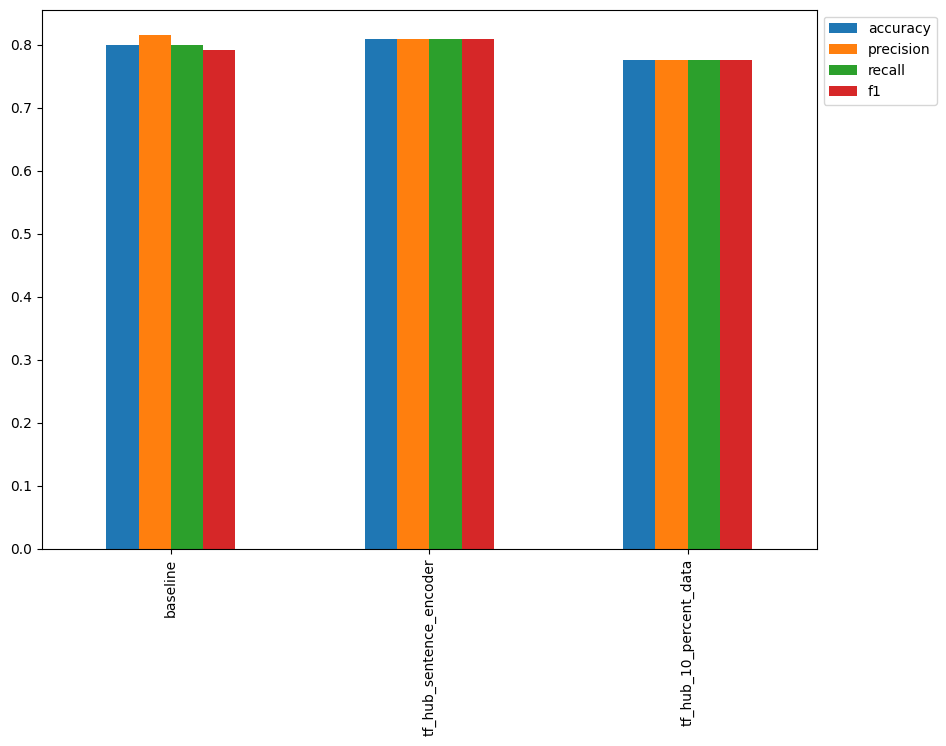

In [65]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

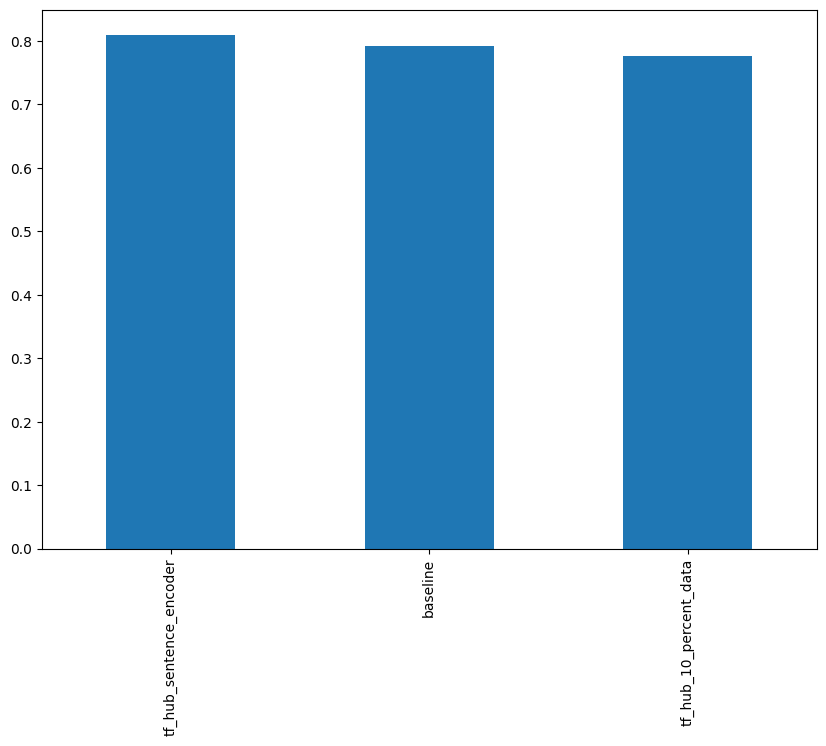

In [66]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

**Combining all our models or model ensembling**

In [67]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_3_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1.], dtype=float32)>

In [68]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 76.62508207485227,
 'precision': 0.774216613721238,
 'recall': 0.7662508207485227,
 'f1': 0.7671930542070399}

In [69]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [70]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
all_model_results

/tmp/ipykernel_42/1210658126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


,accuracy,precision,recall,f1
baseline,0.799081,0.814636,0.799081,0.792016
tf_hub_sentence_encoder,0.809586,0.809285,0.809586,0.808612
tf_hub_10_percent_data,0.775443,0.775443,0.775443,0.775443
ensemble_results,76.625082,0.774217,0.766251,0.767193


In [71]:
model_2.save("model_2.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
loaded_model_2 = tf.keras.models.load_model("model_2.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [73]:
loaded_model_2.evaluate(val_sentences, val_labels)

48/48 [==============================] - 1s 9ms/step - loss: 0.4388 - accuracy: 0.8096


[0.43875154852867126, 0.8095863461494446]

In [74]:
model_2.save("model_2_SavedModel_format")

In [75]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_2_SavedModel = tf.keras.models.load_model("model_2_SavedModel_format")

In [76]:
# Evaluate loaded SavedModel format
loaded_model_2_SavedModel.evaluate(val_sentences, val_labels)


48/48 [==============================] - 1s 11ms/step - loss: 0.4388 - accuracy: 0.8096


[0.43875154852867126, 0.8095863461494446]

**Finding the most wrong examples**

In [77]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_2_preds,
                       "pred_prob": tf.squeeze(model_2_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.227251
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.843414
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986125
3,@camilacabello97 Internally and externally scr...,1,0.0,0.175901
4,Radiation emergency #preparedness starts with ...,1,1.0,0.779091


In [78]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
881,@adorableappple No reported flooding po in the...,0,1.0,0.977174
846,Mourning notices for stabbing arson victims st...,0,1.0,0.950137
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.949593
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.943720
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.929002
759,FedEx will no longer transport bioterror patho...,0,1.0,0.921927
769,Weapons stolen from National Guard Armory in N...,0,1.0,0.903653
814,the MOFO in DC will leave our military unarmed...,0,1.0,0.901432
1467,Bloor/Ossington arsonist also burned a mattres...,0,1.0,0.894600
1099,One thing you can be sure of. There will never...,0,1.0,0.894501


In [79]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9771736860275269
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.9501370787620544
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9495932459831238
Text:
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

----

Target: 0, Pred: 1, Prob: 0.9437202215194702
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.9290019273757935
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9219271540641785
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, P

In [80]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.04753553122282028
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04519452527165413
Text:
the sunset boys wreck my bed   original 1979 usa gimp label  vinyl 7' 45  newave http://t.co/X0QLgwoyMT http://t.co/hQNx8qMeG3

----

Target: 1, Pred: 0, Prob: 0.044734153896570206
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04321179538965225
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.04125083237886429
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

Target: 1, Pred: 0, Prob: 0.040615830570459366
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target:

**Predictions on the text dataset**

In [81]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_2.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.31986913084983826
Text:
@ohnoeunhae Hyukkie &amp; Chullie aim to completely obliterate the ship that was Eunhae.

----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.044599782675504684
Text:
Trying to get higher in the bathroom at work with my pen b4 I go and demolish my food ??????

----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.04487580433487892
Text:
Need to drown in ice cream??

----

1/1 [==============================] - 0s 41ms/step
Pred: 0, Prob: 0.3735474944114685
Text:
Still traumatised at the sight of an old woman throwing her shit out the window ?????

----

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.05920782312750816
Text:
SCREAMS I LOVE THIS VINE https://t.co/PKnBZLHOSc

----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.35022807121276855
Text:
@martinsymiguel @FilipeCoelho92 FATALITY

----

1/1 [========

In [82]:
##Predict on the tweet wild
new_tweet = "Life is like a race: so please run fast and with concentration"
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [83]:
predict_on_sentence(model=model_2,
                    sentence=new_tweet)

1/1 [==============================] - 0s 38ms/step
Pred: 0.0 (not real disaster) Prob: 0.2667304575443268
Text:
Life is like a race: so please run fast and with concentration


In [84]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() 
  model.predict(samples) 
  end_time = time.perf_counter()
  total_time = end_time-start_time 
  time_per_pred = total_time/len(val_sentences) 
  return total_time, time_per_pred

In [86]:
model_2_total_pred_time, model_2_time_per_pred = pred_timer(model_2, val_sentences)
model_2_total_pred_time, model_2_time_per_pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

48/48 [==============================] - 0s 8ms/step


(0.036026727000262326, 2.365510636918078e-05)

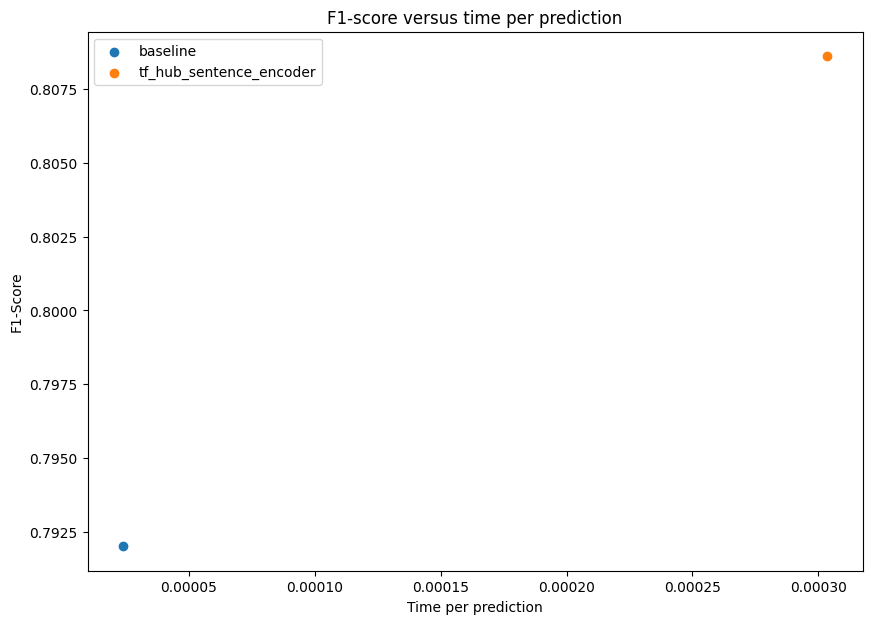

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_2_time_per_pred, model_2_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");